In [24]:
import geopy
import pandas as pd
import numpy as np

from pyproj import Geod
from shapely.geometry import Point, LineString
from sklearn.cluster import DBSCAN
from utils import meter_distance
from tqdm import tqdm

tqdm.pandas()

X = pd.read_csv('data/stores_train.csv')
X_extra = pd.read_csv('data/stores_extra.csv')
X_full = pd.concat([X, X_extra], axis=0).reset_index()
spatial = pd.read_csv('data/grunnkrets_norway_stripped.csv')
age = pd.read_csv('data/grunnkrets_age_distribution.csv')

{-1: 2865, 0: 16336, 1: 435, 2: 452, 3: 1993, 4: 2453, 5: 179, 6: 2994, 7: 113, 8: 328, 9: 243, 10: 237, 11: 260, 12: 133, 13: 77, 14: 616, 15: 64, 16: 117, 17: 1736, 18: 1103, 19: 513, 20: 116, 21: 175, 22: 335, 23: 113, 24: 173, 25: 87, 26: 128, 27: 109, 28: 73, 29: 59, 30: 62, 31: 91, 32: 69, 33: 809, 34: 51, 35: 129, 36: 353, 37: 721, 38: 170, 39: 119, 40: 70, 41: 208, 42: 46, 43: 202, 44: 44, 45: 142, 46: 33, 47: 191, 48: 76, 49: 110, 50: 90, 51: 37, 52: 170, 53: 68, 54: 96, 55: 38, 56: 34, 57: 34, 58: 70, 59: 68, 60: 171, 61: 99, 62: 36, 63: 64, 64: 54, 65: 66, 66: 37, 67: 66, 68: 51, 69: 64, 70: 90, 71: 87, 72: 30, 73: 168, 74: 36, 75: 43, 76: 51, 77: 59, 78: 71, 79: 33, 80: 74, 81: 89, 82: 30, 83: 87, 84: 39, 85: 154, 86: 63, 87: 39, 88: 37, 89: 88, 90: 34, 91: 76, 92: 42, 93: 36, 94: 65, 95: 31, 96: 47, 97: 31, 98: 32, 99: 26, 100: 31}
102


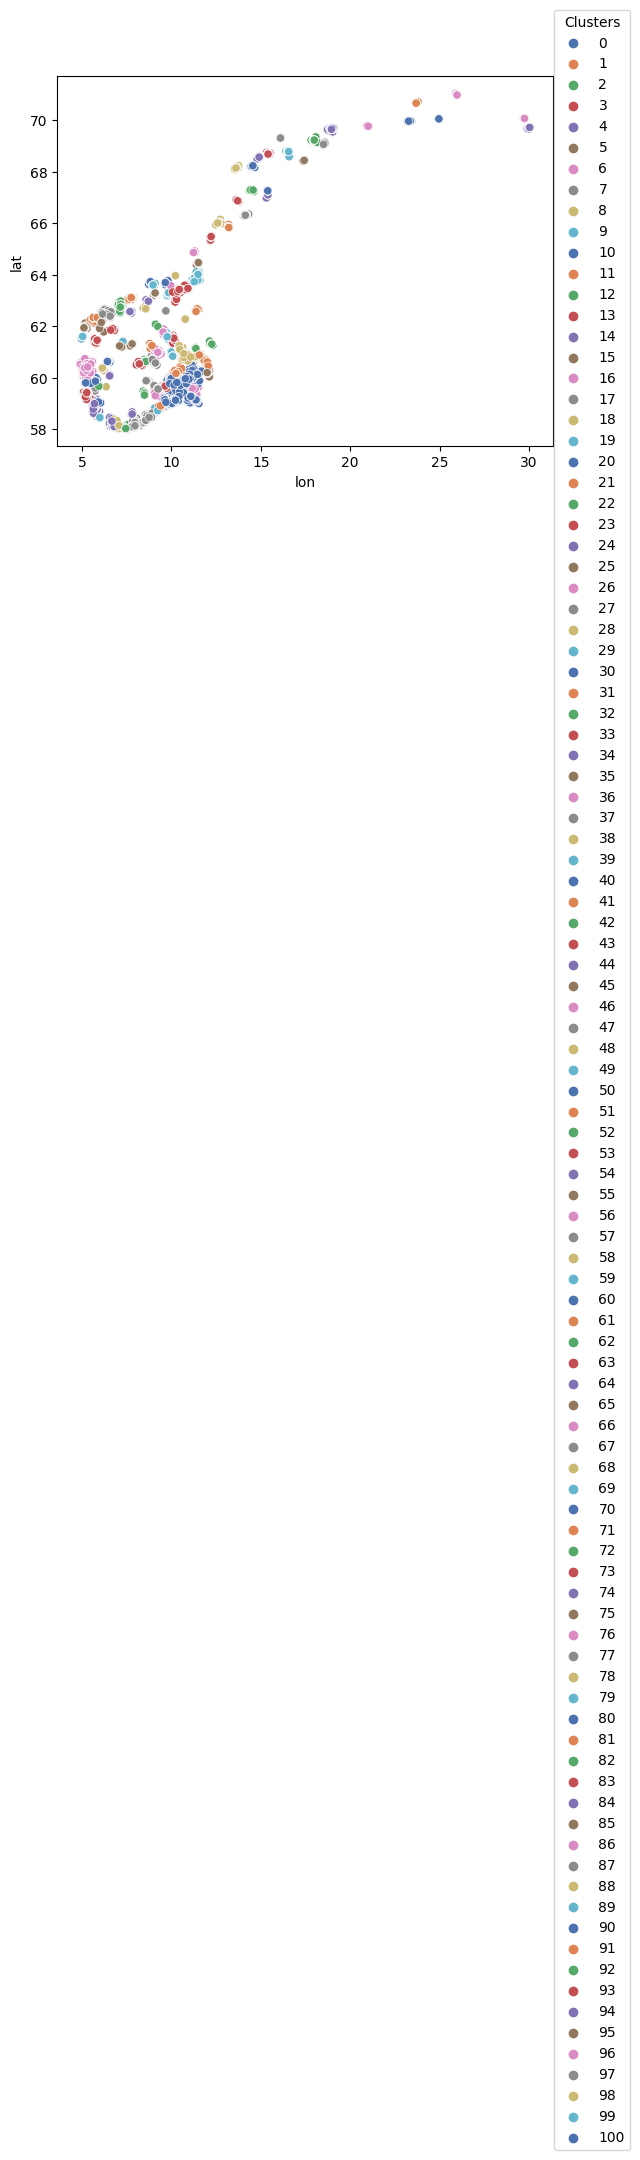

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

clusters = DBSCAN(eps=0.12, min_samples=30)
cl = clusters.fit_predict(X_full[['lat', 'lon']].to_numpy())
cl_counts = dict(zip(*np.unique(cl, return_counts=True)))

print(cl_counts)
print(len(set(cl)))

X_full['cluster_id'] = cl
X_full['cluster_member_count'] = X_full.apply(lambda row: cl_counts[row.cluster_id], axis=1)

X_no_outliers = X_full[X_full.cluster_id != -1]
cluster_centroids = X_no_outliers.groupby('cluster_id')[['lat', 'lon']].mean()

# def closest_centroid(lat, lon):
#     dist_series = cluster_centroids.apply(lambda row: meter_distance(lat, lon, row.lat, row.lon), axis=1)
#     return dist_series.min()


# X_full['closest_cluster_centroid_dist'] = X_full.progress_apply(lambda row: closest_centroid(row.lat, row.lon), axis=1)
# X_full[X_full.cluster_id == 0]


p = sns.scatterplot(data=X_no_outliers, x="lon", y="lat", hue=X_no_outliers.cluster_id, legend="full", palette="deep")
sns.move_legend(p, "upper right", bbox_to_anchor=(1.17, 1.2), title='Clusters')
plt.show()

969


ValueError: AxesSubplot(0.125,0.11;0.775x0.77) has no legend attached.

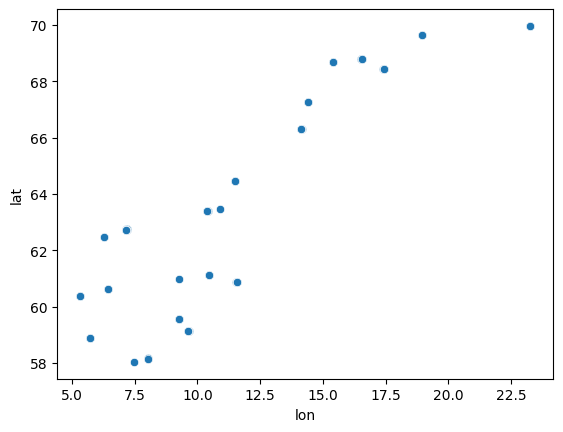

In [46]:
# X_full[X_full.cluster_id == 0].sort_values(by='closest_cluster_centroid_dist')
X_close = X_full[X_full.closest_cluster_centroid_dist < 500]
print(len(X_close))
p = sns.scatterplot(data=X_close, x="lon", y="lat")
# p = sns.scatterplot(data=X_close, x="lon", y="lat", hue=np.log(X_close.closest_cluster_centroid_dist), palette='Blues_r')
sns.move_legend(p, "upper right", bbox_to_anchor=(1.17, 1.2), title='Clusters')
plt.show()
# X_full.head()
# X_full[X_full.index.duplicated()]

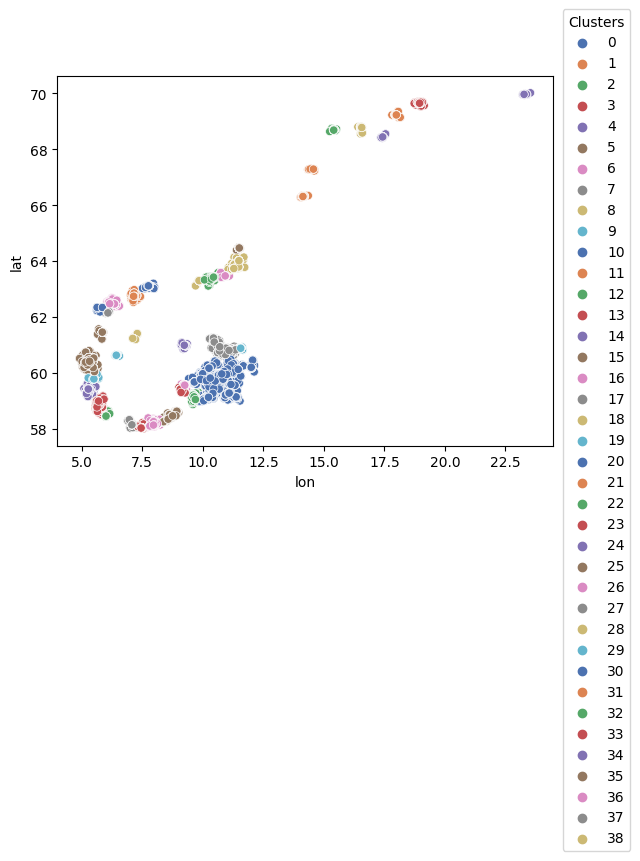

In [35]:
p = sns.scatterplot(data=X_no_outliers, x="lon", y="lat", hue=X_no_outliers.cluster_id, legend="full", palette="deep")
sns.move_legend(p, "upper right", bbox_to_anchor=(1.17, 1.2), title='Clusters')
plt.show()

In [ ]:
gk_muni = spatial[['grunnkrets_id', 'municipality_name']]

old_shape = X.shape
# print(len(X.merge(gk_muni, on='grunnkrets_id', how='right')))
X = X.merge(gk_muni, on='grunnkrets_id', how='left')

_ = X.groupby(['municipality_name'])['lat', 'lon'].apply(lambda x: x.sum() / (x.count()))[['lat', 'lon']]
X = X.merge(_, on=['municipality_name'], how='left', suffixes=(None, '_center')).drop_duplicates()
assert X.shape[0] == old_shape[0]

def meter_distance(lat1, lon1, lat2, lon2):
    line_string = LineString([Point(lon1, lat1), Point(lon2, lat2)])
    geod = Geod(ellps="WGS84")
    return geod.geometry_length(line_string)


X.fillna(value={'lat_center': 63, 'lon_center': 10}, inplace=True)
X.isnull().sum()

X['dist_to_center'] = X.apply(lambda row: meter_distance(row.lat, row.lon, row.lat_center, row.lon_center), axis=1)
X[20:30]

assert X.shape[0] == old_shape[0]



/tmp/ipykernel_1162638/2877985337.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  _ = X.groupby(['municipality_name'])['lat', 'lon'].apply(lambda x: x.sum() / (x.count()))[['lat', 'lon']]


In [ ]:
X[['municipality_name', 'lat_center']]


,municipality_name,lat_center
0,Drammen,59.740315
2,Oslo,59.919972
4,Ringerike,60.176006
6,Bodø,67.283052
8,Trondheim,63.418063
...,...,...
25678,Horten,59.404396
25680,Gjøvik,60.806942
25682,Skedsmo,59.957614
25684,Sandnes,58.857718
